### How to use SOTA, which updates frequently, in a very short time? 

#### Bring your own container - BYOC 

In [23]:
!pip install seaborn 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [1]:
%%bash 
cd byoc/smore/
./build_and_push.sh smore-byoc

Login Succeeded

Step 1/7 : FROM ubuntu:18.04
18.04: Pulling from library/ubuntu
7595c8c21622: Pulling fs layer
d13af8ca898f: Pulling fs layer
70799171ddba: Pulling fs layer
b6c12202c5ef: Pulling fs layer
b6c12202c5ef: Waiting
70799171ddba: Verifying Checksum
70799171ddba: Download complete
d13af8ca898f: Download complete
b6c12202c5ef: Verifying Checksum
b6c12202c5ef: Download complete
7595c8c21622: Verifying Checksum
7595c8c21622: Download complete
7595c8c21622: Pull complete
d13af8ca898f: Pull complete
70799171ddba: Pull complete
b6c12202c5ef: Pull complete
Digest: sha256:a61728f6128fb4a7a20efaa7597607ed6e69973ee9b9123e3b4fd28b7bba100b
Status: Downloaded newer image for ubuntu:18.04
 ---> 2eb2d388e1a2
Step 2/7 : RUN apt-get update &&     apt-get install -y --no-install-recommends         ca-certificates         cmake         build-essential         gcc         g++         git &&     rm -rf /var/lib/apt/lists/*
 ---> Running in 0229a8d8efe8
Get:1 http://security.ubuntu.com/ubuntu bion

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [73]:
%env docker_name=230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc

env: docker_name=230755935769.dkr.ecr.us-east-1.amazonaws.com/smore-byoc


In [3]:
!pygmentize ./byoc/smore/build_and_push.sh

#!/bin/bash
image=$1
if [ "$image" == "" ]
then
    echo "Usage: $0 <image-name>"
    exit 1
fi
account=$(aws sts get-caller-identity --query Account --output text)
region=$(aws configure get region)
fullname="${account}.dkr.ecr.${region}.amazonaws.com/${image}:latest"

aws ecr describe-repositories --repository-names "${image}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${image}" > /dev/null
fi

$(aws ecr get-login --region ${region} --no-include-email)

docker build -t ${image} . 
docker tag ${image} ${fullname}

docker push ${fullname}


In [4]:
!cat ./byoc/smore/dockerfile

FROM ubuntu:18.04


RUN apt-get update && \
    apt-get install -y --no-install-recommends \
        ca-certificates \
        cmake \
        build-essential \
        gcc \
        g++ \
        git && \
    rm -rf /var/lib/apt/lists/*

RUN git clone https://github.com/cnclabs/smore.git && cd smore && make 

RUN cp -r /smore /app/
ENV PATH="/app:${PATH}"
WORKDIR /app 
COPY train /app/





### Data Preparation 

In [45]:
import sys
sys.path.append('../')

from preprocessing.imdb_datareader import IMDBDataReader
from preprocessing.smore_transformer import SmoreDataTransformer
import pickle 

user_item  = pickle.load(open("data/user_item.p", "rb")) 


users = {}
items = {}
train_user_item = user_item[:int(len(user_item)*0.8)]
test_user_item = user_item[int(len(user_item)*0.8):]
transformer = SmoreDataTransformer(users, items, train_user_item)
X_train, Y_train, _, _, nFeatures = transformer.get_feature_vectors(users, items, train_user_item)
X_test, Y_test,X_cold_test, Y_cold_test, nFeatures = transformer.get_feature_vectors(users, items, test_user_item)

In [75]:
bucket = 'recommendation-demo-yianc'
prefix = 'sagemaker/smore-movielens'
train_key      = 'net'
train_prefix   = '{}/{}'.format(prefix, 'train')
output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)


import io,boto3
import sagemaker.amazon.common as smac

def writeDatasetToSmoreTXT(X, bucket, prefix, key, Y=None):
    f_name = key+".txt"
    f = open(f_name, 'w')
    for i in range(0, len(X)): 
        raw = X[i]
        n1 = raw[0][0]
        n2 = raw[1][0]
        w = Y[i]
        f.write("{} {} {}\n".format(n1, n2, w))
    
    s3_client = boto3.client('s3')
    object_name = '{}/{}'.format(prefix, f_name)
    response = s3_client.upload_file(f_name, bucket, object_name)
 
    return 's3://{}/{}'.format(bucket,object_name)
    
train_data = writeDatasetToSmoreTXT(X_train, bucket, train_prefix, train_key,  Y_train)    
  
print('Output: {}'.format(output_prefix))

Output: s3://recommendation-demo-yianc/sagemaker/smore-movielens/output


In [8]:
!cat net.txt | head -n 5

140 1554 1.0
140 1588 1.0
140 1601 1.0
140 1476 1.0
140 1463 1.0
cat: write error: Broken pipe


In [10]:
!mkdir ${PWD}/model
!docker run -it -v ${PWD}:/opt/ml/input/data/train/ -v ${PWD}/model:/opt/ml/model smore-byoc train 

mkdir: cannot create directory '/opt/ml/model': File exists
Connections Preview:
	# of connection:	80000
Connections Loading:
	Progress:		100.00 %
	# of vertex:		2367
Build the Alias Method:
	Reconstructing Graph ...
	Building Alias Tables ...
	Finished.
Model Setting:
	dimension:		64
Model:
	[DeepWalk]
Learning Parameters:
	walk_times:		1
	walk_steps:		40
	window_size:		5
	negative_samples:	5
	alpha:			0.025
	workers:		4
Start Training:
	Alpha: 0.025000	Progress: 100.00 %
Save Model:
	Save to </opt/ml/model/rep_dw.txt>


In [11]:
cat ${PWD}/model/rep_dw.txt | head -n 5 

2367 64
140 -0.13918 0.144323 -0.145353 -0.464579 0.0772066 0.15232 -0.112674 -0.322923 0.2675 -0.101603 -0.0146694 0.0705175 0.0156831 0.00380718 -0.325228 -0.0601948 0.107802 -0.0685099 0.154058 -0.147099 -0.0330674 -0.00939774 0.0645282 -0.441968 0.11935 0.210575 0.0496161 0.0338709 -0.355026 0.175955 -0.129919 -0.016507 -0.244929 0.227855 -0.0315906 0.0180166 0.0428991 0.170605 -0.179131 -0.0648499 -0.118441 0.0250853 -0.0424473 0.152672 0.0491395 -0.124284 -0.101458 -0.187577 -0.0201318 -0.452173 -0.145697 -0.118999 -0.00704862 0.1064 -0.176412 0.0743557 0.0417864 -0.124323 0.0403594 0.184415 -0.186706 -0.115341 -0.12359 0.0782242
1554 -0.148423 0.149647 -0.151697 -0.468872 0.0721284 0.155906 -0.112257 -0.343919 0.277911 -0.0958412 0.00127018 0.0796493 0.0149868 5.65722e-05 -0.334234 -0.0636322 0.117647 -0.0856429 0.158582 -0.142591 -0.0155182 -0.00428371 0.073432 -0.452992 0.119455 0.212828 0.058863 0.0409188 -0.369573 0.184304 -0.127855 -0.0108783 -0.255405 0.237515 -0.0359274 0

In [76]:
import boto3 
import os 
import sagemaker 
from sagemaker import get_execution_role



region = boto3.Session().region_name
crole = get_execution_role()
container = os.environ['docker_name']

smore = sagemaker.estimator.Estimator(image_name=container,
                                   role=crole, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())



smore.fit({'train': train_data})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-18 14:17:19 Starting - Starting the training job...
2020-08-18 14:17:22 Starting - Launching requested ML instances.........
2020-08-18 14:19:03 Starting - Preparing the instances for training...
2020-08-18 14:19:49 Downloading - Downloading input data...
2020-08-18 14:20:00 Training - Downloading the training image...
2020-08-18 14:20:41 Uploading - Uploading generated training model
2020-08-18 14:20:41 Completed - Training job completed
mkdir: cannot create directory '/opt/ml/model': File exists
Connections Preview:
#011# of connection:#0110#015#011# of connection:#01110000#015#011# of connection:#01120000#015#011# of connection:#01130000#015#011# of connection:#01140000#015#011# of connection:#01150000#015#011# of connection:#01160000#015#011# of connection:#01170000#015#011# of connection:#01179665
Connections Loading:
#011Progress:#011#0110.00 %#015#011Progress:#011#01112.55 %#015#011Progress:#011#01125.10 %#015#011Progress:#011#01137.66 %#015#011Progress:#011#01150.21 %#0

In [15]:
import os 
model_file_name = "model.tar.gz"
model_full_path = smore.output_path +"/"+ smore.latest_training_job.job_name +"/output/"+model_file_name
print ("Model Path: ", model_full_path)

#Download FM model 
os.system("aws s3 cp "+model_full_path+ " .")

#Extract model file for loading to MXNet
os.system("tar xzvf "+model_file_name)



Model Path:  s3://recommendation-demo-yianc/sagemaker/smore-movielens/output/smore-byoc-2020-08-18-09-46-56-949/output/model.tar.gz


0

In [16]:
!ls -al 

total 24696
drwxrwxr-x 7 ec2-user ec2-user     4096 Aug 18 09:50 .
drwxrwxr-x 7 ec2-user ec2-user     4096 Aug 18 08:58 ..
-rw-rw-r-- 1 ec2-user ec2-user   111562 Aug 18 09:06 01-Movie_Lens_Data_Prepareration.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   491473 Aug 18 09:50 02-Factorization_Machine-IMDB-UI.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   323569 Aug 18 09:50 03-Smore-IMDB-UI.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   153907 Aug 18 08:58 04-Factorization_Machine-IMDB.ipynb
-rw-rw-r-- 1 ec2-user ec2-user     8189 Aug 18 08:58 05-XGBoost-IMDB.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   403570 Aug 18 08:58 06-comprehend_on_amz_products.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   226793 Aug 18 08:58 07-Factorization_Machine-AMZ-Comprehend_Added.ipynb
drwxrwxr-x 3 ec2-user ec2-user     4096 Aug 18 08:58 byoc
drwxrwxr-x 2 ec2-user ec2-user     4096 Aug 18 09:05 data
-rw-rw-r-- 1 ec2-user ec2-user     8196 Aug 18 08:58 .DS_Store
-rw-rw-r-- 1 ec2-user ec2-user 14087874 Aug 18 08:58 Factorization Machine - AMZ

In [8]:
!pip install annoy 

     |████████████████████████████████| 644 kB 14.2 MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=281630 sha256=d42c518c044904fa77ad2c2b5720148006132acdd057c212112d498af5ba9261
  Stored in directory: /home/ec2-user/.cache/pip/wheels/d8/ca/fd/2f44fca421bd8b28677e120346db1d1bc71233009ffdeadaa6
Successfully built annoy
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [9]:
from annoy import AnnoyIndex
#to be modified 
dim = 64
t = AnnoyIndex(dim, 'euclidean')  # Length of item vector that will be indexed
for k, v in item_vectors.items():
    t.add_item(int(k), v)

t.build(100)
t.save('smore.ann')



True

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


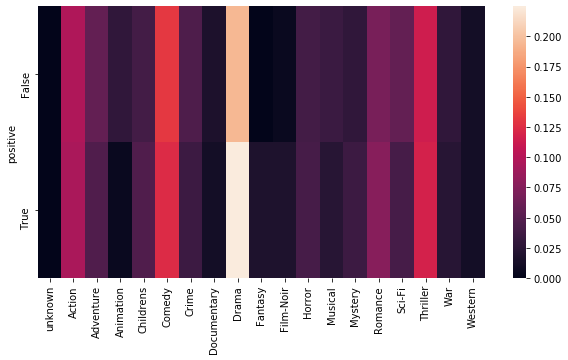

In [30]:
import json

import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


user_item_df = pd.read_pickle("data/user_item_df.p")
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


def plot_heat_map(df, figsize=(10,7)): 
    df = df.div(df.sum(axis=1), axis=0)     
    plt.subplots(figsize=figsize)
    sns.heatmap(df)


# test_user_idx = 89
test_user_idx = 200
u_id = user_inv_idx[test_user_idx]

tester_df = user_item_df[user_item_df['uid']==int(u_id)]
tester_df['positive'] = tester_df['rating'] >3 

review = tester_df[['positive']+genres].groupby(['positive']).sum()
plot_heat_map(review, figsize=(10,5))

In [31]:
import urllib.parse

def get_imdb_query(q):
    return 'https://www.imdb.com/find?q={}'.format(urllib.parse.quote(q))

def print_movie_title(df):
    imdb_search_url = ""
    for index, row in df.iterrows():
        print (row['title'], get_imdb_query(row['title']))


test_positive_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']>3)][['title']]
print_movie_title(test_positive_df[0:10])




Ridicule (1996) https://www.imdb.com/find?q=Ridicule%20%281996%29
Net, The (1995) https://www.imdb.com/find?q=Net%2C%20The%20%281995%29
12 Angry Men (1957) https://www.imdb.com/find?q=12%20Angry%20Men%20%281957%29
Event Horizon (1997) https://www.imdb.com/find?q=Event%20Horizon%20%281997%29
Star Trek: First Contact (1996) https://www.imdb.com/find?q=Star%20Trek%3A%20First%20Contact%20%281996%29
Operation Dumbo Drop (1995) https://www.imdb.com/find?q=Operation%20Dumbo%20Drop%20%281995%29
Kansas City (1996) https://www.imdb.com/find?q=Kansas%20City%20%281996%29
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) https://www.imdb.com/find?q=Horseman%20on%20the%20Roof%2C%20The%20%28Hussard%20sur%20le%20toit%2C%20Le%29%20%281995%29
Cinema Paradiso (1988) https://www.imdb.com/find?q=Cinema%20Paradiso%20%281988%29
Die Hard (1988) https://www.imdb.com/find?q=Die%20Hard%20%281988%29


In [32]:
test_negative_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']<3)][['title']]
print_movie_title(test_negative_df[0:10])

Ice Storm, The (1997) https://www.imdb.com/find?q=Ice%20Storm%2C%20The%20%281997%29
Ulee's Gold (1997) https://www.imdb.com/find?q=Ulee%27s%20Gold%20%281997%29
Return of the Jedi (1983) https://www.imdb.com/find?q=Return%20of%20the%20Jedi%20%281983%29
Evil Dead II (1987) https://www.imdb.com/find?q=Evil%20Dead%20II%20%281987%29
Jurassic Park (1993) https://www.imdb.com/find?q=Jurassic%20Park%20%281993%29
Dirty Dancing (1987) https://www.imdb.com/find?q=Dirty%20Dancing%20%281987%29
Ulee's Gold (1997) https://www.imdb.com/find?q=Ulee%27s%20Gold%20%281997%29
Cold Comfort Farm (1995) https://www.imdb.com/find?q=Cold%20Comfort%20Farm%20%281995%29
River Wild, The (1994) https://www.imdb.com/find?q=River%20Wild%2C%20The%20%281994%29
Spitfire Grill, The (1996) https://www.imdb.com/find?q=Spitfire%20Grill%2C%20The%20%281996%29


In [70]:
nns = t.get_nns_by_vector(user_vectors[str(test_user_idx)], 100, search_k=-1, include_distances=False) 

for movie_id in nns[:10]:
    print_movie_title(item_df[item_df['iid']==int(movie_id)])

Twister (1996) https://www.imdb.com/find?q=Twister%20%281996%29
Crow, The (1994) https://www.imdb.com/find?q=Crow%2C%20The%20%281994%29
Absolute Power (1997) https://www.imdb.com/find?q=Absolute%20Power%20%281997%29
Three Musketeers, The (1993) https://www.imdb.com/find?q=Three%20Musketeers%2C%20The%20%281993%29
One Fine Day (1996) https://www.imdb.com/find?q=One%20Fine%20Day%20%281996%29
Net, The (1995) https://www.imdb.com/find?q=Net%2C%20The%20%281995%29
Adventures of Robin Hood, The (1938) https://www.imdb.com/find?q=Adventures%20of%20Robin%20Hood%2C%20The%20%281938%29
Rob Roy (1995) https://www.imdb.com/find?q=Rob%20Roy%20%281995%29
Real Genius (1985) https://www.imdb.com/find?q=Real%20Genius%20%281985%29
Desperate Measures (1998) https://www.imdb.com/find?q=Desperate%20Measures%20%281998%29


In [71]:
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

item_genres_df = item_df[['iid']+genres]


popularity = user_item_df[user_item_df['rating']>3].groupby('iid').count()['uid'].to_dict() 

user_inv_idx = {} 
item_inv_idx = {} 

for k, v in transformer.u_idx.items():
    user_inv_idx[v] = k 
    
for k, v in transformer.i_idx.items():
    item_inv_idx[v] = k 
    


def get_answers():
    answer = {} 
    for ui in test_user_item: 
        uid = ui[0]
        iid = ui[1]
        rating = ui[2]
        if uid not in answer:  
            answer[uid] = set() 
        if rating > 0: 
            answer[uid].add(iid)
    return answer
                

            
def similarity(genre_df1, genre_df2): 
    sim = 0 
    for i, c in enumerate(genre_df1.columns): 
        if c != 'iid':
            if genre_df1[c].iloc[0] == genre_df2[genres][c].iloc[0]: 
                sim += 1 
    return sim / len(genres) 
           
    
answer = get_answers() 

def get_metrics_related_to_recommendation(user_vectors,u_idx,t,answer):
    all_pop = 0 
    hits = 0 
    topk = 10
    valid_user_nb = 0 
    rcmded = set()
    diversity = [] 
    
    for uid in answer.keys():
        if uid in u_idx.keys() and uid in user_vectors: 
            nns = t.get_nns_by_vector(user_vectors[uid], 100, search_k=-1, include_distances=False) 
            pred = set()
            valid_user_nb += 1 
            all_sim = []
            for i, movieid in enumerate(nns[:topk]): 
                rcmded.add(movieid)
                if movieid in popularity: 
                    all_pop += popularity[movieid] 
                pred.add(str(movieid))
                for j, movieid_other in enumerate(nns[:topk]):
                    if j < i:
                        movie_a_df = item_genres_df[item_genres_df['iid'] == int(movieid)]
                        movie_b_df = item_genres_df[item_genres_df['iid'] == int(movieid_other)]
                        sim = similarity(movie_a_df, movie_b_df)
                        all_sim.append(sim) 
            diversity.append(1/np.mean(np.asarray(all_sim)))             

            hits += len(pred.intersection(answer[uid]))
    print("Novelty:{}".format(1/(all_pop/topk/valid_user_nb)))
    print("Hits@10:{}".format(hits))
    print("Coverage:{}".format(len(rcmded)))
    print("Diversity:{}".format(np.mean(np.asarray(diversity))))
    
get_metrics_related_to_recommendation(user_vectors,transformer.u_idx,t,answer)    

Novelty:0.022313127556712536
Hits@10:18
Coverage:461
Diversity:1.1782381237343063


In [42]:
#Extract model data
import numpy as np 
import pandas as pd 
from preprocessing.smore_datareader import SmoreDataReader


smorereader = SmoreDataReader(transformer.u_idx, transformer.i_idx, "rep_dw.txt")
user_vectors = smorereader.read_user_data()
item_vectors = smorereader.read_item_data()
 



vectors_to_visualize = [] 
genre_labels = [] 
for k, v in item_vectors.items(): 
    iid = k
    for index, item_info in item_df[item_df['iid']==int(iid)].iterrows():     
        for g in genres: 
            if item_info[g] > 0:
                vectors_to_visualize.append(np.asarray(v)) 
                genre_labels.append(g)
                
    


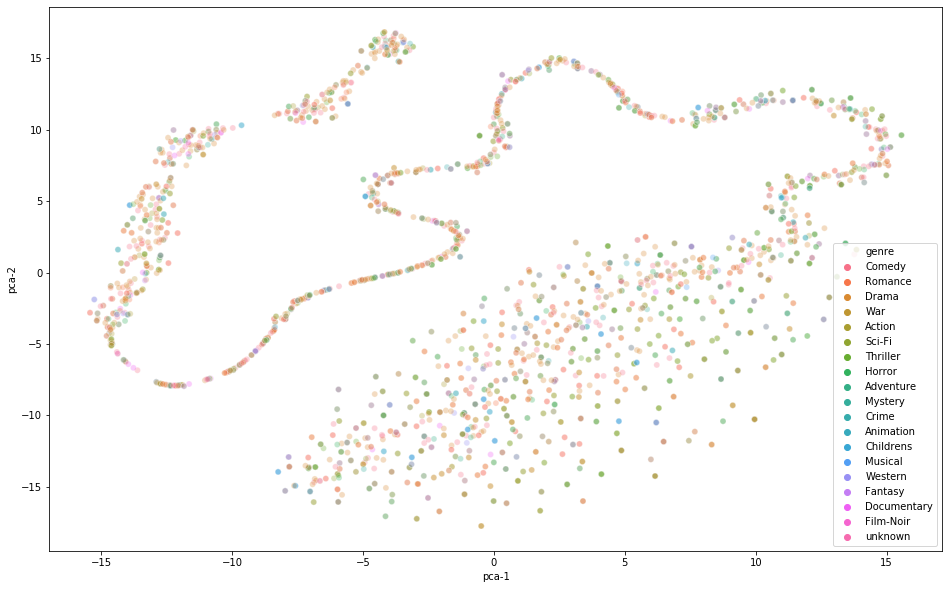

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

vectors_to_visualize = np.asarray(vectors_to_visualize)                
pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_result = pca.fit_transform(vectors_to_visualize)
d = {} 
d['pca-1'] = pca_result[:,0]
d['pca-2'] = pca_result[:,1]
d['genre'] = genre_labels

df = pd.DataFrame(data=d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="genre",
    data=df,
    legend="full",
    alpha=0.3
)